In [24]:
!pip install langchain[google-vertexai]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [1]:
# Authenticate Colab notebook with Google OAuth
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [2]:
# Get API keys from Colab's Secrets module
from google.colab import userdata
API_KEY = userdata.get('GOOGLE_API_KEY')
PROJECT_ID = userdata.get('GOOGLE_PROJ_ID1')

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt
import pickle
import google.generativeai as genai
import vertexai
from vertexai import agent_engines

In [4]:
# Load the training data
df = pd.read_csv('AI_agent_train_sepsis.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198433 entries, 0 to 198432
Data columns (total 57 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         198433 non-null  int64  
 1   bloc               198433 non-null  float64
 2   icustayid          198433 non-null  float64
 3   charttime          198433 non-null  float64
 4   gender             198433 non-null  float64
 5   age                198433 non-null  float64
 6   elixhauser         198433 non-null  float64
 7   re_admission       198433 non-null  float64
 8   Weight_kg          198433 non-null  float64
 9   GCS                198433 non-null  float64
 10  HR                 198433 non-null  float64
 11  SysBP              198433 non-null  float64
 12  MeanBP             198433 non-null  float64
 13  DiaBP              198433 non-null  float64
 14  RR                 198433 non-null  float64
 15  SpO2               198433 non-null  float64
 16  Te

In [5]:
# Treat records with the same icustayid as time series by sorting according to icustayid first and then charttime
df = df.sort_values(by=['icustayid', 'charttime'])

In [6]:
# Function to count the number of groups with NaNs. Is helpful to calculate the effectiveness of different imputation methods
def count_records_w_missing_features(df):
  patient_ids = df['icustayid'].unique()
  num_na_records = 0

  for pid in patient_ids:
    patient_record = df[df['icustayid'] == pid]
    if patient_record.isna().values.any():
      num_na_records += 1

  print("Number of records with NaN values:", num_na_records)
  print("Total number of records:", len(patient_ids))

In [7]:
# List of all columns that act as features for the model
feature_cols = [col for col in df.columns if col not in ['icustayid', 'charttime', 'mortality_90d', 'bloc', 'Unnamed: 0']]

# Since 0 values in some columns can indicate missing data, investigate how many 0s each column has
for col in feature_cols:
  num_0_values = (df[col] == 0).sum()
  print(col, "Number of 0 values:", num_0_values)
  print()

# Replace 0 values with NaN if 0 inidicates missing value
cols_where_0_is_ok = ['gender', 're_admission', 'mechvent', 'median_dose_vaso', 'max_dose_vaso',
                      'input_total', 'input_4hourly', 'output_total', 'output_4hourly', 'SOFA', 'SIRS']
cols_where_0_means_missing = [col for col in feature_cols if col not in cols_where_0_is_ok]
df[cols_where_0_means_missing] = df[cols_where_0_means_missing].replace(0, np.nan)

gender Number of 0 values: 110453

age Number of 0 values: 0

elixhauser Number of 0 values: 6512

re_admission Number of 0 values: 183830

Weight_kg Number of 0 values: 153

GCS Number of 0 values: 0

HR Number of 0 values: 2

SysBP Number of 0 values: 8

MeanBP Number of 0 values: 2

DiaBP Number of 0 values: 7

RR Number of 0 values: 30

SpO2 Number of 0 values: 0

Temp_C Number of 0 values: 0

FiO2_1 Number of 0 values: 0

Potassium Number of 0 values: 0

Sodium Number of 0 values: 0

Chloride Number of 0 values: 0

Glucose Number of 0 values: 0

BUN Number of 0 values: 2

Creatinine Number of 0 values: 16

Magnesium Number of 0 values: 3

Calcium Number of 0 values: 5

Ionised_Ca Number of 0 values: 3

CO2_mEqL Number of 0 values: 0

SGOT Number of 0 values: 11

SGPT Number of 0 values: 24

Total_bili Number of 0 values: 610

Albumin Number of 0 values: 0

Hb Number of 0 values: 2

WBC_count Number of 0 values: 3

Platelets_count Number of 0 values: 0

PTT Number of 0 values: 3

P

In [8]:
count_records_w_missing_features(df)

Number of records with NaN values: 11579
Total number of records: 15124


In [9]:
# Imputation Strategy Number 1: Forward Fill + Backup: Backward Fill + Second Backup: Group Mean + Third Backup: Global Mean
df_imp_fill = df.copy()
df_imp_fill = df_imp_fill.groupby('icustayid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)

for col in feature_cols:
  df_imp_fill[col] = df_imp_fill.groupby('icustayid')[col].transform(
      lambda x: x.fillna(x.mean())
  )

for col in feature_cols:
  df_imp_fill[col] = df_imp_fill[col].fillna(df_imp_fill[col].mean())

<ipython-input-9-d5219c2502b9>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp_fill = df_imp_fill.groupby('icustayid').apply(lambda group: group.ffill().bfill()).reset_index(drop=True)


In [10]:
# Imputation Strategy Number 2: Interpolation
df_imp_interp = df.copy()
df_imp_interp['charttime'] = pd.to_datetime(df_imp_interp['charttime'])
df_imp_interp = df_imp_interp.groupby('icustayid').apply(
    lambda group: group.set_index('charttime').interpolate(method='time').reset_index()
).reset_index(drop=True)

<ipython-input-10-16c468beee16>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imp_interp = df_imp_interp.groupby('icustayid').apply(


In [11]:
print("Imp 1:")
count_records_w_missing_features(df_imp_fill)
print("Imp 2:")
count_records_w_missing_features(df_imp_interp)

Imp 1:
Number of records with NaN values: 0
Total number of records: 15124
Imp 2:
Number of records with NaN values: 5826
Total number of records: 15124


In [12]:
# Compress each group into a single row by replacing each feature column with its mean, std, min, max, and last within the group
def extract_features(df, feature_cols):
  feature_list = []
  labels = []

  for group_id, group in df.groupby('icustayid'):
    features = {}
    for col in feature_cols:
      features[f'{col}_mean'] = group[col].mean()
      features[f'{col}_std'] = group[col].std()
      features[f'{col}_min'] = group[col].min()
      features[f'{col}_max'] = group[col].max()
      features[f'{col}_last'] = group[col].iloc[-1]

    label = group['mortality_90d'].iloc[0]
    labels.append(label)
    feature_list.append(features)

  X = pd.DataFrame(feature_list)
  y = np.array(labels)
  return X, y

In [13]:
# Create 3 datasets - Non-imputed, Imp 1 (Fill + Mean), Imp 2 (Interpolation)
X, y = extract_features(df, feature_cols)
X_imp_fill, y_imp_fill = extract_features(df_imp_fill, feature_cols)
X_imp_interp, y_imp_interp = extract_features(df_imp_interp, feature_cols)

def count_rows_w_nans(X):
  nan_counts_per_row = X.isnull().sum(axis=1)
  rows_with_nan = nan_counts_per_row > 0
  print("Number of rows with NaN:", rows_with_nan.sum())
  print("Total number of rows:", len(X))

# Check how many NaNs are still there in the imputed datasets
count_rows_w_nans(X)
count_rows_w_nans(X_imp_fill)
count_rows_w_nans(X_imp_interp)

Number of rows with NaN: 3420
Total number of rows: 15124
Number of rows with NaN: 243
Total number of rows: 15124
Number of rows with NaN: 1072
Total number of rows: 15124


In [14]:
# Train Random Forest and XGBoost on non-imputed dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest on No Imputation:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("XGBoost on No Imputation:")
print(classification_report(y_test, y_pred))

Random Forest on No Imputation:
              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      1869
         1.0       0.53      0.38      0.44       400

    accuracy                           0.83      2269
   macro avg       0.70      0.65      0.67      2269
weighted avg       0.81      0.83      0.82      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:16:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on No Imputation:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91      1869
         1.0       0.64      0.23      0.34       400

    accuracy                           0.84      2269
   macro avg       0.75      0.60      0.63      2269
weighted avg       0.82      0.84      0.81      2269



In [15]:
# Train Random Forest and XGBoost on dataset imputed using Strategy 1 (Fill + Mean)
X_train, X_test, y_train, y_test = train_test_split(X_imp_fill, y_imp_fill, test_size=0.15, random_state=42)

mask = ~np.isnan(X_train).any(axis=1)

X_train = X_train[mask]
y_train = y_train[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest on Imputation 1:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("XGBoost on Imputation 1:")
print(classification_report(y_test, y_pred))

Random Forest on Imputation 1:
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88      1869
         1.0       0.44      0.42      0.43       400

    accuracy                           0.81      2269
   macro avg       0.66      0.65      0.66      2269
weighted avg       0.80      0.81      0.80      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:17:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on Imputation 1:
              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      1869
         1.0       0.53      0.29      0.37       400

    accuracy                           0.83      2269
   macro avg       0.69      0.62      0.64      2269
weighted avg       0.80      0.83      0.81      2269



In [16]:
# Train Random Forest and XGBoost on dataset imputed using Strategy 2 (Interpolation)
X_train, X_test, y_train, y_test = train_test_split(X_imp_interp, y_imp_interp, test_size=0.15, random_state=42)

mask = ~np.isnan(X_train).any(axis=1)

X_train = X_train[mask]
y_train = y_train[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

model = RandomForestClassifier(
  n_estimators=100,
  max_depth=10,
  class_weight='balanced',
  random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest on Imputation 2:")
print(classification_report(y_test, y_pred))

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("XGBoost on Imputation 2:")
print(classification_report(y_test, y_pred))

Random Forest on Imputation 2:
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      1869
         1.0       0.46      0.42      0.44       400

    accuracy                           0.81      2269
   macro avg       0.67      0.66      0.66      2269
weighted avg       0.80      0.81      0.81      2269



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:20:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost on Imputation 2:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.90      1869
         1.0       0.56      0.32      0.41       400

    accuracy                           0.84      2269
   macro avg       0.71      0.63      0.65      2269
weighted avg       0.81      0.84      0.82      2269



In [17]:
# Use the best training configuration

mask = ~np.isnan(X_imp_interp).any(axis=1)

# Apply the mask to X and y
X_imp_interp = X_imp_interp[mask]
y_imp_interp = y_imp_interp[mask]

sm = SMOTE(sampling_strategy=1.0)
X_resampled, y_resampled = sm.fit_resample(X_imp_interp, y_imp_interp)

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

model.fit(X_resampled, y_resampled)

# Save the trained model
filename = 'mortality_prediction_model.sav'
pickle.dump(model, open(filename, 'wb'))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:22:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


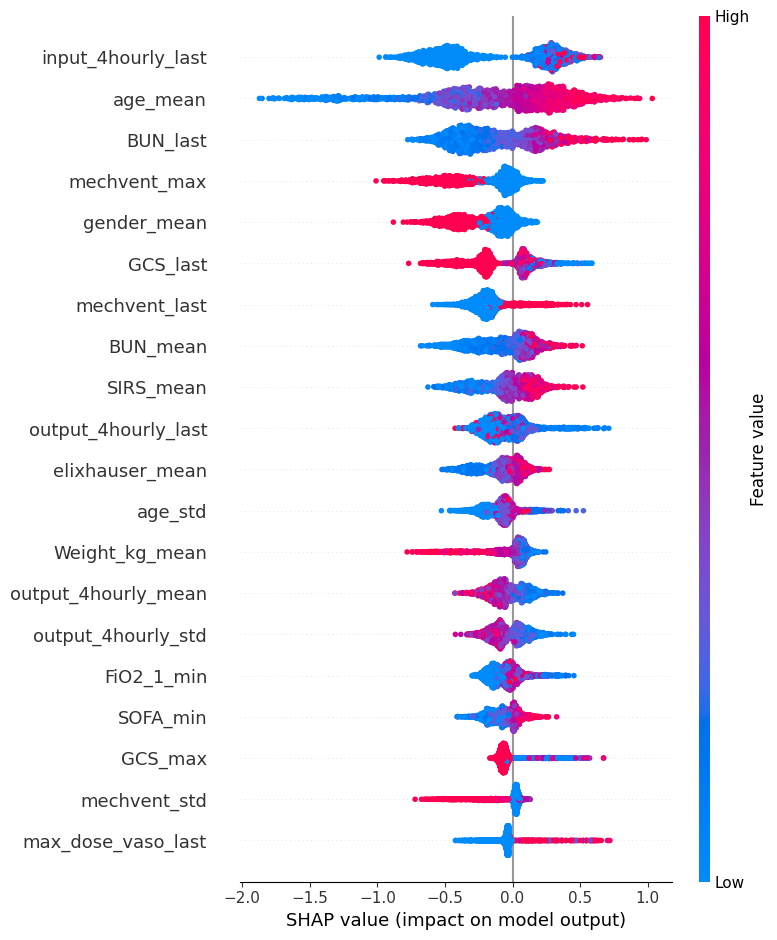

In [26]:
# Load the trained model
filename = 'mortality_prediction_model.sav'
model = pickle.load(open(filename, 'rb'))

# Use SHAP to find out importance of each feature in the model (across all patients)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, show=True)

In [27]:
# Load patients from test dataset
test_df = pd.read_csv('AI_agent_test_sepsis_features.csv')
test_df = test_df.sort_values(by=['icustayid', 'charttime'])

feature_cols = [col for col in test_df.columns if col not in ['icustayid', 'charttime', 'mortality_90d', 'bloc', 'Unnamed: 0']]

cols_where_0_is_ok = ['gender', 're_admission', 'mechvent', 'median_dose_vaso', 'max_dose_vaso',
                      'input_total', 'input_4hourly', 'output_total', 'output_4hourly', 'SOFA', 'SIRS']
cols_where_0_means_missing = [col for col in feature_cols if col not in cols_where_0_is_ok]
test_df[cols_where_0_means_missing] = test_df[cols_where_0_means_missing].replace(0, np.nan)

# Only use Imputation Strategy Number 2: Interpolation since it's better
test_df_imp = test_df.copy()
test_df_imp['charttime'] = pd.to_datetime(test_df_imp['charttime'])
test_df_imp = test_df_imp.groupby('icustayid').apply(
    lambda group: group.set_index('charttime').interpolate(method='time').reset_index()
).reset_index(drop=True)

def extract_features_from_test(test_df, feature_cols):
  feature_list = []

  for group_id, group in test_df.groupby('icustayid'):
    features = {}
    for col in feature_cols:
      features[f'{col}_mean'] = group[col].mean()
      features[f'{col}_std'] = group[col].std()
      features[f'{col}_min'] = group[col].min()
      features[f'{col}_max'] = group[col].max()
      features[f'{col}_last'] = group[col].iloc[-1]

    feature_list.append(features)

  X = pd.DataFrame(feature_list)
  return X

test_X = extract_features_from_test(test_df, feature_cols)
test_X_imp = extract_features_from_test(test_df_imp, feature_cols)
test_y_pred = model.predict(test_X)
test_y_imp_pred = model.predict(test_X_imp)

explainer = shap.TreeExplainer(model)
shap_values = explainer(test_X)
shap_values_imp = explainer(test_X_imp)

<ipython-input-27-af439475b54b>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df_imp = test_df_imp.groupby('icustayid').apply(


In [28]:
# Create a LLM that will explain the results of the mortality prediction
mortality_explainer = genai.GenerativeModel(
    model_name="gemini-2.0-flash",
    system_instruction=[
        "You are an AI chatbot that explains the results of another AI model that analyzes EHR records.",
        "You will be given a mortality score (1 means they will die in 90 days, 0 means they will not).",
        "Then, you will be given a list of features from the EHR data that were most important in deciding the mortality.",
        "Explain the mortality score and features to a doctor in natural language. Sound confident."
    ],
)

In [29]:
# Create 2 tools that will be binded to the AI agent
# The first one fetches the patient records using icustayid
# The second one predicts mortality, mortality with imputation, and finds the most important features using SHAP
# It then prints out a natural language response to explain these results, using the mortality_explainer LLM
def get_patient_records(icustayid: int):
  """Get patient records according to their icustayid

  Args:
    icustayid: The ID of a patient's ICU stay i.e. a patient's unique ID

  Returns:
    A dataframe of rows which share the same icustayid
  """
  global test_df
  patient_records = test_df[test_df['icustayid'] == icustayid]
  print(patient_records)
  return patient_records

def predict_patient_mortality(icustayid: int):
  """Predict a patient's predicted mortality within 90 days (i.e. mortality_90d)

  Args:
    icustayid: The ID of a patient's ICU stay i.e. a patient's unique ID

  Returns:
    1 if the patient is going to die in 90 days, 0 otherwise
  """
  global test_df, mortality_explainer
  unique_ids = test_df['icustayid'].unique()
  indices = np.where(unique_ids == icustayid)
  idx = indices[0][0]
  mortality_pred = test_y_pred[idx]
  mortality_pred_imp = test_y_imp_pred[idx]

  # Create feature to shap value dict
  patient_shap_values = shap_values[idx]
  patient_shap_values_imp = shap_values_imp[idx]
  feature_shap_dict = {}
  for i in range(len(test_X.columns)):
    feature_shap_dict[test_X.columns[i]] = patient_shap_values.values[i]

  shap.plots.waterfall(patient_shap_values, max_display=10)
  top_10_shaps = sorted(feature_shap_dict.items(), key=lambda item: abs(item[1]), reverse=True)[:10]
  top_10_features = [key for key, value in top_10_shaps]

  chat = mortality_explainer.start_chat()

  message = "The mortality prediction without imputing was " + str(mortality_pred) + ". "
  message += "The mortality prediction with imputing was " + str(mortality_pred_imp) + ". "
  message += "These were the top 10 features according to SHAP value: "
  for ft in top_10_features:
    message += ft + ", "
  message += "Please explain these results in natural language"
  response = chat.send_message(message).text
  print(response)

  return mortality_pred

In [30]:
# Create the AI agent and bind the tools
genai.configure(api_key=API_KEY)

vertexai.init(api_key=API_KEY, project=PROJECT_ID)
model = "gemini-2.0-flash"
agent = agent_engines.LangchainAgent(
    model=model,
    tools=[get_patient_records, predict_patient_mortality],
)

In [31]:
response = agent.query(
    input="Get the patient records of icustayid = 200014"
)
response

    Unnamed: 0  bloc  icustayid     charttime  gender       age  elixhauser  \
7           23   1.0   200014.0  4.264269e+09     0.0  30946.97         2.0   
8           24   2.0   200014.0  4.264284e+09     0.0  30946.97         2.0   
9           25   3.0   200014.0  4.264298e+09     0.0  30946.97         2.0   
10          26   4.0   200014.0  4.264312e+09     0.0  30946.97         2.0   
11          27   5.0   200014.0  4.264327e+09     0.0  30946.97         2.0   
12          28   6.0   200014.0  4.264341e+09     0.0  30946.97         2.0   
13          29   7.0   200014.0  4.264356e+09     0.0  30946.97         2.0   
14          30   8.0   200014.0  4.264370e+09     0.0  30946.97         2.0   
15          31   9.0   200014.0  4.264384e+09     0.0  30946.97         2.0   
16          32  10.0   200014.0  4.264399e+09     0.0  30946.97         2.0   
17          33  14.0   200014.0  4.264456e+09     0.0  30946.97         2.0   

    re_admission  Weight_kg        GCS  ...   PaO2_

{'input': 'Get the patient records of icustayid = 200014',
 'output': 'OK. I have retrieved the patient records for icustayid 200014. Do you need anything else?\n'}

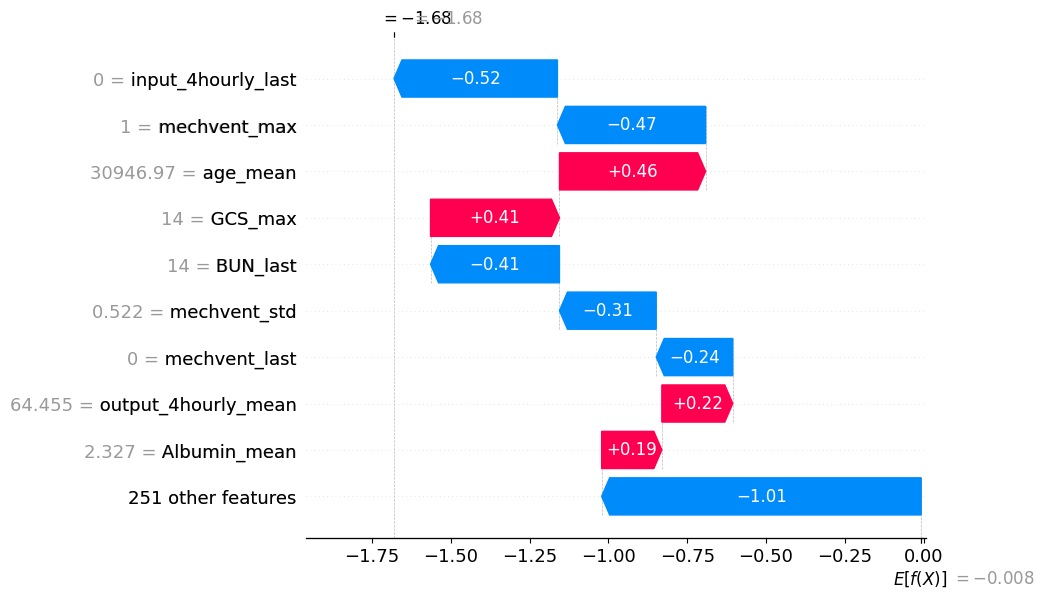

Based on the analysis of the patient's EHR, the model predicts a mortality score of 0, indicating a low probability of death within the next 90 days. Both the model run without imputation and the model run with imputation agreed on this result.

Here's a breakdown of the key factors that influenced this prediction:

*   **input\_4hourly\_last:** The most recent value of fluid intake every 4 hours.
*   **mechvent\_max:** The maximum value of mechanical ventilation.
*   **age\_mean:** The patient's average age.
*   **GCS\_max:** The maximum Glasgow Coma Scale score.
*   **BUN\_last:** The most recent Blood Urea Nitrogen level.
*   **mechvent\_std:** The standard deviation of mechanical ventilation.
*   **mechvent\_last:** The most recent value of mechanical ventilation.
*   **output\_4hourly\_mean:** The average value of fluid output every 4 hours.
*   **Albumin\_mean:** The average Albumin level.
*   **elixhauser\_mean:** The average Elixhauser comorbidity index score.

These features s

{'input': 'Get the patient mortality of icustayid = 200014',
 'output': 'The predicted mortality within 90 days for icustayid 200014 is 0.\n'}

In [32]:
response = agent.query(
    input="Get the patient mortality of icustayid = 200014"
)
response